# Machine Learning for Perovskite Materials

The dataset was already published by Antoine Emery: High-throughput DFT calculations of formation energy, stability and oxygen vacancy formation energy of ABO3 perovskites, from figshare. Dataset. https://doi.org/10.6084/m9.figshare.5334142.v1 

The link to this dataset was found from **matminer**, a Python library for data mining the properties of materials (L. Ward et al, Matminer: An open source toolkit for materials data mining. Comput. Mater. Sci. 152, 60-69 (2018)) 


## Section 1: Data Manupulation

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
import time

### Section 1-1: Data Loading and Primary Observations

In [90]:
#Loading data from local folder
df=pd.read_csv("HighthroughputDFTcalculations.csv")

df.head(5)

,Chemical formula,A,B,In literature,Valence A,Valence B,Radius A [ang],Radius B [ang],Lowest distortion,Formation energy [eV/atom],...,Magnetic moment [mu_B],Volume per atom [A^3/atom],Band gap [eV],a [ang],b [ang],c [ang],alpha [deg],beta [deg],gamma [deg],Vacancy energy [eV/O atom]
0,Ac2O3,Ac,Ac,False,element not in BV,element not in BV,1.12,1.12,cubic,-2.732,...,0.000,20.836,0.332,4.705,4.705,4.705,90.0,90.0,90.0,3.150
1,AcAgO3,Ac,Ag,False,element not in BV,element not in BV,1.12,0.95,orthorhombic,-1.957,...,0.000,14.485,0.000,5.779,6.077,8.248,90.0,90.0,90.0,0.817
2,AcAlO3,Ac,Al,False,element not in BV,element not in BV,1.12,0.54,cubic,-3.532,...,0.000,11.487,4.307,3.858,3.858,3.858,90.0,90.0,90.0,6.695
3,AcAsO3,Ac,As,False,element not in BV,element not in BV,1.12,0.52,orthorhombic,-2.398,...,0.000,14.355,0.000,5.780,6.012,8.262,90.0,90.0,90.0,3.634
4,AcAuO3,Ac,Au,False,element not in BV,element not in BV,1.12,0.93,orthorhombic,-2.006,...,0.000,15.190,0.745,5.899,6.750,7.630,90.0,90.0,90.0,0.807


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Chemical formula            5329 non-null   object 
 1   A                           5329 non-null   object 
 2   B                           5329 non-null   object 
 3   In literature               5329 non-null   bool   
 4   Valence A                   5329 non-null   object 
 5   Valence B                   5329 non-null   object 
 6   Radius A [ang]              5329 non-null   float64
 7   Radius B [ang]              5329 non-null   float64
 8   Lowest distortion           5329 non-null   object 
 9   Formation energy [eV/atom]  5329 non-null   object 
 10  Stability [eV/atom]         5329 non-null   object 
 11  Magnetic moment [mu_B]      5329 non-null   object 
 12  Volume per atom [A^3/atom]  5329 non-null   object 
 13  Band gap [eV]               5329 

### Section 1-2: Data Cleaning 

In [8]:

#columns to be encoded to numeric
col_change=['Formation energy [eV/atom]','Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]']

for i in col_change:
    df[i]=pd.to_numeric(df[i], errors="coerce")
    
# The LowestDist is linked to crystallography of the materials and in the dataset, there are many features which
#might have underlying interaction with LowestDist. The question is that how the crystal structure of the material can
#influence the properties of the materials.So the LowetDsit is a our target label.  

# Since the unique values of label are low, it is possible to apply manual ordinal encoding. 

ordinal_encoding={"cubic":1, "orthorhombic":2, "rhombohedral":3,"tetragonal":4,"-":5 }
df["LowestDist"]=df["Lowest distortion"].replace(ordinal_encoding)

#col_obj contains features which are numeric and will be used for the model training. The new dataframe is called DFT.

col_obj=[col for col in df.columns if df[col].dtypes in ["float64", "int64"]]
DFT=df[col_obj]   #  new DataFrame

#Missing Values

#The feature "Magnetic moment" has large percentage missing values, and currently it is not our focus. 

DFT=DFT.drop("Magnetic moment [mu_B]", axis=1)
DFT=DFT.dropna(axis=0)

#Defining Features and Label

features=DFT.drop("LowestDist", axis=1)
labels=DFT["LowestDist"]

# Train Test split for the features and lables
X_train, X_test, y_train, y_test=train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)


### Section 1-3: Correlation to the label

The pairplot is divided into two plots for better visualization. The first plot shows positive correlation between features and the label and the second plot for those features with negative correlation to the label.

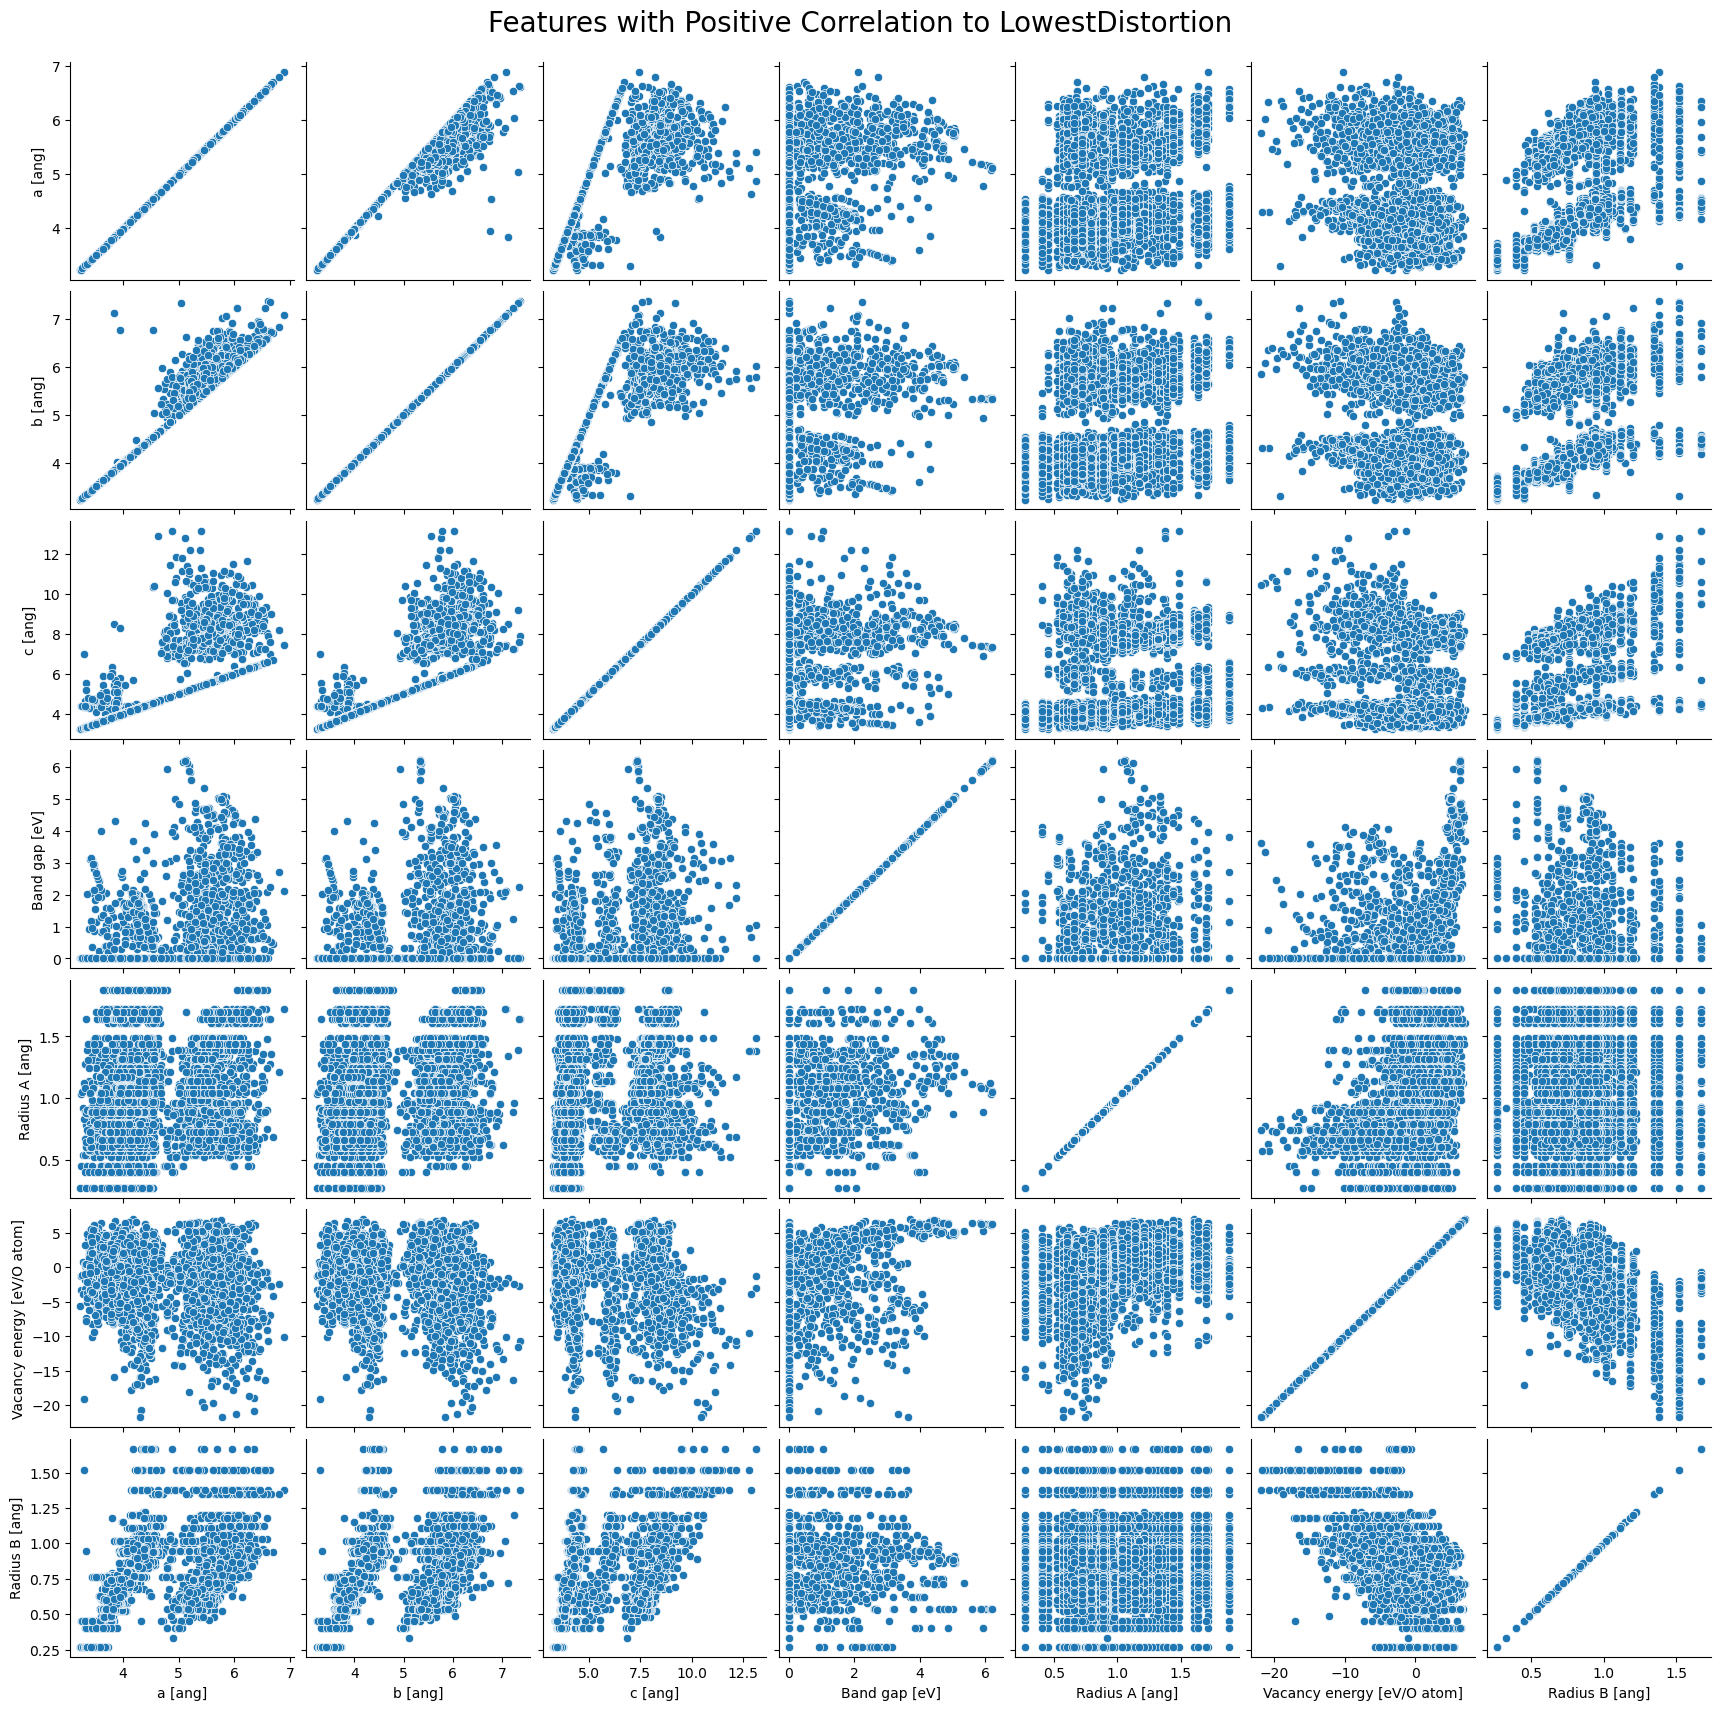

In [86]:
positive_cor= sns.pairplot(data=DFT[DFT.corr()["LowestDist"].sort_values(ascending=False)[1:8].index],diag_kind=None, )
positive_cor.fig.subplots_adjust(top=.95)
positive_cor.fig.suptitle("Features with Positive Correlation to LowestDistortion",size=20)
plt.show();

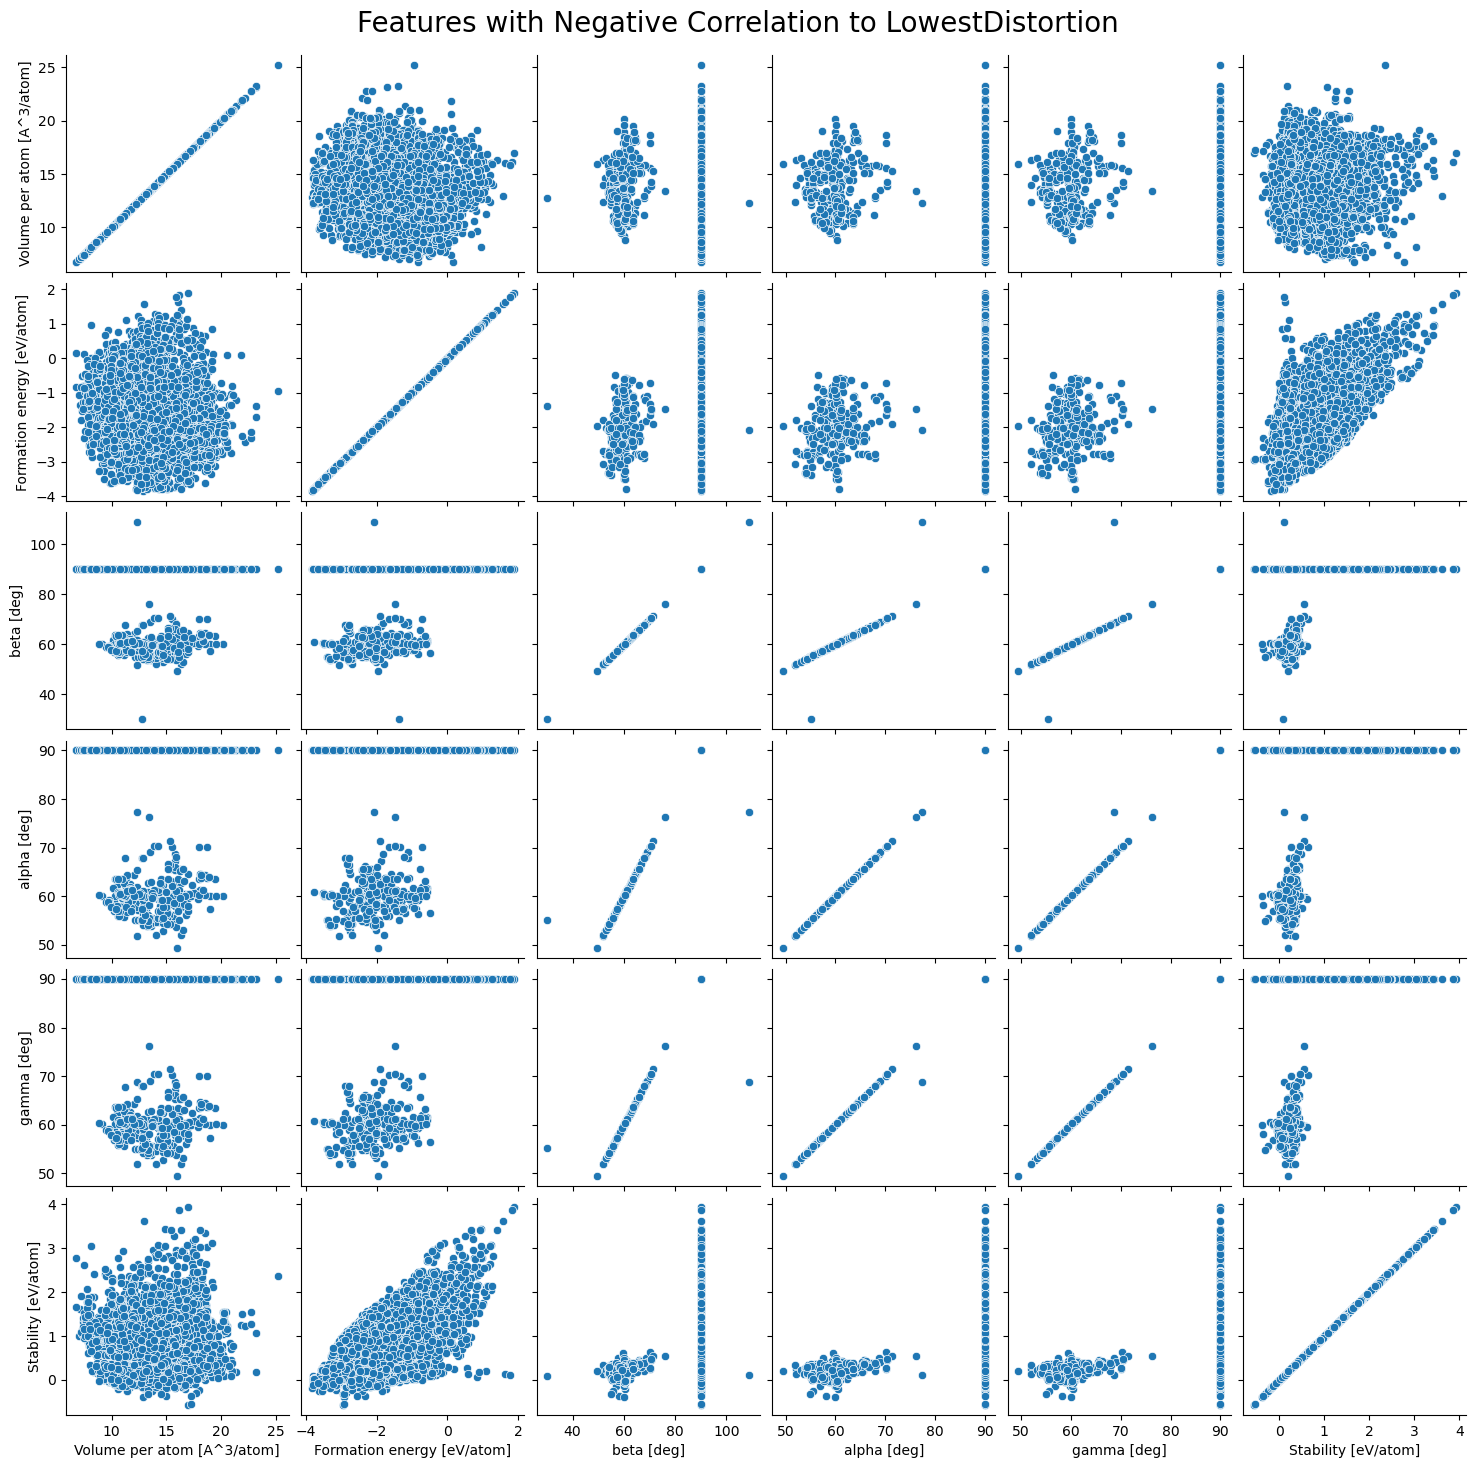

In [87]:
negative_cor=sns.pairplot(data=DFT[DFT.corr()["LowestDist"].sort_values(ascending=False)[8:].index],diag_kind=None)
negative_cor.fig.subplots_adjust(top=.95)
negative_cor.fig.suptitle("Features with Negative Correlation to LowestDistortion", size=20)
plt.show();

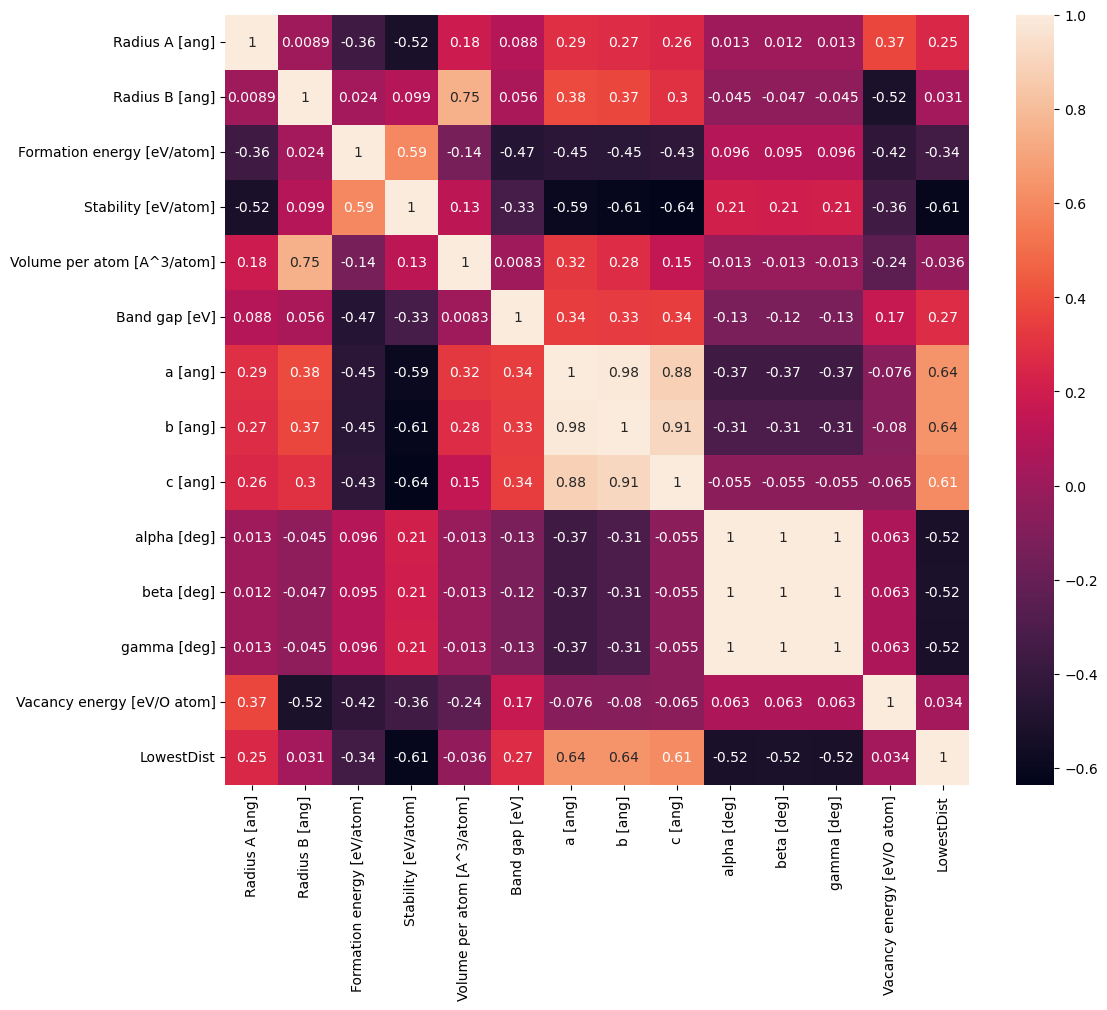

In [73]:
plt.figure(figsize=(12,10))
sns.heatmap(DFT.corr(),annot=True );

## Section 2: Define Models

In [106]:
#LogisticRegression classifier
def log_reg_model():
    """ This function applies logistic regression. The preprocessing includes both StandardScaler and 
    PolynomialFeature stpes """
    
    #Hpyerparameter tunning: solver Saga works for large multiclass datasets
    #the degree of Polynomial feature is chosen after try out different values
    
    pipe_model=Pipeline(steps=[("scale",StandardScaler()),
                             ("clf",LogisticRegression(max_iter=100000, random_state=42))],
                   )
    param_grid= {
           "scale__with_mean":[True, False],
           "scale__with_std":[True, False],
           "clf__C":[0.05, 0.1,0.5],
           "clf__penalty":["l2"],
            "clf__solver":["saga"],
               }
    
    grid_reg=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    
    grid_reg.fit(X_train, y_train)
    
    #Assigning the best parameters found by GridSearch to variables to be used in the model
    a1=grid_reg.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_reg.best_estimator_.get_params()["scale__with_std"]
    a3=grid_reg.best_estimator_.get_params()["clf__C"]
    a4=grid_reg.best_estimator_.get_params()["clf__penalty"]
    a5=grid_reg.best_estimator_.get_params()["clf__solver"]
    
    reg_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    LogisticRegression(C=a3,penalty=a4, solver=a5, max_iter=10000)
    )
    # The score of trained and test datasets 
    train_score=reg_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=reg_final.fit(X_test, y_test).score(X_test, y_test)

    return reg_final, train_score, test_score

# RandomForest Classifier
def randfor_model():
    """ This function applies RandomForest classifier on dataset with StandardScaler as preprocessing step
    and it returns the final model with best parameters, and the score for train and test"""
    
    
    #Hpyerparameter tunning is limited to only three important paramters of the rf classifeir 

    pipe_model=Pipeline(steps=[("scale", StandardScaler()), ("rf",RandomForestClassifier(random_state=42))]) 

    param_grid={
        "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
              "rf__n_estimators":[10, 50,100],
              "rf__max_depth":[4,5,6],
              "rf__max_features":[4,5,6]
    }


    grid_rf=GridSearchCV(pipe_model,param_grid=param_grid, cv=10,n_jobs=4, verbose=False, scoring="accuracy")

    grid_rf.fit(X_train, y_train)
    
    #Assigning the best parameters found by GridSearch to variables to be used in the model
    a1=grid_rf.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_rf.best_estimator_.get_params()["scale__with_std"]
    a3=grid_rf.best_estimator_.get_params()["rf__n_estimators"]
    a4=grid_rf.best_estimator_.get_params()["rf__max_depth"]
    a5=grid_rf.best_estimator_.get_params()["rf__max_features"]
    
    rf_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    RandomForestClassifier(n_estimators=a3, max_depth=a4, max_features=a5)
    )
    # The score of trained and test datasets 
    train_score=rf_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=rf_final.fit(X_test, y_test).score(X_test, y_test)

    return rf_final, train_score, test_score

#KNearestNeighbor Classifier
def knn_model():
    " This function applies KNN model on the dataset, with StanddardScaling as a preprocessing step  "
    
    #Hpyerparameter tunning 

    knn=KNeighborsClassifier()
    pipe_model= Pipeline(steps=[("scale",StandardScaler()),("knn",knn)])
    param_grid={
            "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
              "knn__n_neighbors":[4, 5],
              "knn__leaf_size":[2, 3],
              "knn__p":[1]}
    grid_knn=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    grid_knn.fit(X_train, y_train)
  
    #Assigning the best parameters found by GridSearch to variables to be used in the model
    a1=grid_knn.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_knn.best_estimator_.get_params()["scale__with_std"]
    a3=grid_knn.best_estimator_.get_params()['knn__n_neighbors']
    a4=grid_knn.best_estimator_.get_params()['knn__leaf_size']
    a5=grid_knn.best_estimator_.get_params()['knn__p']
    
    knn_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    KNeighborsClassifier(n_neighbors=a3, leaf_size=a4, p=a5)
    )
    # The score of trained and test datasets 
    train_score=knn_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=knn_final.fit(X_test, y_test).score(X_test, y_test)

    return knn_final, train_score, test_score


# AdaBoost Classifeir 
def ada_boost_model():
    
    """ AdaBoost Classifier is implemented with StandardScaler as preprocessing step """
    #Hpyerparameter tunning 

    pipe_model=Pipeline(steps=[("scale",StandardScaler()),("ada",AdaBoostClassifier(random_state=42, algorithm="SAMME"))])
                               
    param_grid={
        "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
               "ada__n_estimators":[5, 10, 50],
               "ada__learning_rate":[0.01, 0.1, 1]}

    grid_ada=GridSearchCV(pipe_model, param_grid, cv=10,n_jobs=4, scoring="accuracy")

    grid_ada.fit(X_train, y_train)
    
    #Assigning the best parameters found by GridSearch to variables to be used in the model
    a1=grid_ada.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_ada.best_estimator_.get_params()["scale__with_std"]
    a3=grid_ada.best_estimator_.get_params()['ada__n_estimators']
    a4=grid_ada.best_estimator_.get_params()['ada__learning_rate']
    
    ada_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    AdaBoostClassifier(n_estimators=a3,learning_rate=a4)
    )
    # The score of trained and test datasets from AdaBoost Classifier
    train_score=ada_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=ada_final.fit(X_test, y_test).score(X_test, y_test)

    return ada_final, train_score, test_score

# Provide the name of models and their functions which were defined previously
def get_models():
    
    """ The name of all models which are used for training and already defined as a function"""
    
    models = dict()
    models["LogReg"]=log_reg_model()
    models["RandFor"]=randfor_model()
    models["knn"] = knn_model()
    models["AdaBoost"]=ada_boost_model()

    return models



def score(name, model):
    
    """ The classification report and scoring for train and test datasets as a pandas dataframe """
    
    y_pred=model[0].predict(X_test)
    macro_ave=classification_report(y_test, y_pred, output_dict=True).get("macro avg")
    weighted_ave= classification_report(y_test, y_pred, output_dict=True).get("weighted avg")
    
    score_classification=pd.DataFrame(
        {"parameters":macro_ave.keys(),"macro_ave_"+name:macro_ave.values(),"weighted_ave_"+name:weighted_ave.values()
        }
                            )   
    
    score_series = pd.Series({"score_train_"+name:model[1], "score test_"+name: model[2]})
    
    score_list=pd.concat([score_classification, score_series.to_frame().T],ignore_index=True, axis=0 )
    score_list.style.format("{:.3%}", na_rep="--")
    return score_list
    
# A loop over all models to print the scores and classification report     
for name, model in get_models().items():
    print(score(name, model))


  parameters  macro_ave_LogReg  weighted_ave_LogReg  score_train_LogReg  \
0  precision          0.996798             0.991969                 NaN   
1     recall          0.909091             0.991864                 NaN   
2   f1-score          0.942833             0.990987                 NaN   
3    support       1475.000000          1475.000000                 NaN   
4        NaN               NaN                  NaN            0.992149   

   score test_LogReg  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4           0.991864  
  parameters  macro_ave_RandFor  weighted_ave_RandFor  score_train_RandFor  \
0  precision           0.999192              0.997973                  NaN   
1     recall           0.977273              0.997966                  NaN   
2   f1-score           0.987690              0.997919                  NaN   
3    support        1475.000000           1475.000000                  NaN   
4        NaN         

## Section 4: Stacking and final model

the train score is  0.8924105844722303
the test score is  0.895593220338983


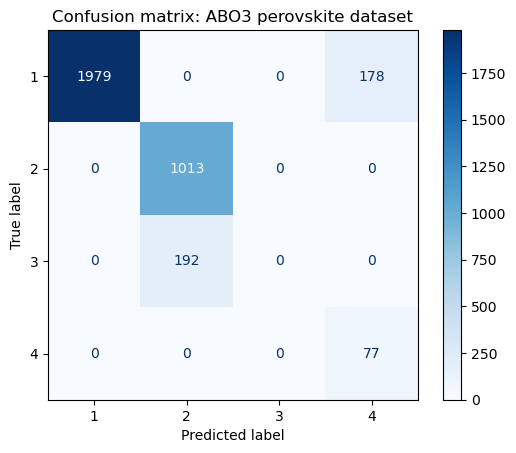

The percentage of the true lables predicted by the model 89.55932203389831 % 

Total Duration of Calculation is: 0:00:13.301056


In [100]:
#
# The base learners are combination of regression, KMeans and tree based algirithm 

base_learner=[
    ("base_lr", log_reg_model()[0]),
    ("base_rf", randfor_model()[0]), 
    ("base_knn", knn_model()[0])
    ]

# The final classifier is AdaBoost 
clf=StackingClassifier(estimators=base_learner, final_estimator=ada_boost_model()[0], cv=10, n_jobs=4)

start_time=datetime.now()

# Calculating the scoring for the train and test datasets
print("the train score is ",clf.fit(X_train, y_train).score(X_train, y_train))
print("the test score is ",clf.fit(X_train, y_train).score(X_test, y_test))

# Plotting the confusion matrix as an interactive for label prediction
from sklearn.metrics import ConfusionMatrixDisplay

clf_display=ConfusionMatrixDisplay.from_estimator(clf,X_train, y_train,
                                                  labels=clf.classes_,cmap=plt.cm.Blues,colorbar=True)
clf_display.ax_.set_title("Confusion matrix: ABO3 perovskite dataset")
plt.show()

y_pred = clf.predict(X_test)

# This is equivalent to test_score
print(f"The percentage of the true lables predicted by the model {len(y_test[y_test == y_pred])*100/len(y_test)} %", "\n")

end_time=datetime.now()

print(f"Total Duration of Calculation is: {(end_time - start_time)}")